In [280]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

color_lst = ['#059ff6', '#f22e92', '#7565df', '#8fd5fa', '#0c385b', '#a1c1ea']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_lst) 




In [281]:
experiment = pd.read_csv('../data/analytical_take_home_data_v3.csv')
experiment.head()

,treatment,company_size,campaign_spend,campaign_budget
0,False,small,10.4477,3.9035
1,False,medium,3.7776,1.9872
2,False,medium,46.1880,55.4523
3,False,small,6.6271,6.5136
4,False,small,92.3405,83.1018


In [282]:
# Data is collected from 15,474 advertisers with the experimentation randomly splitting advertisers 
# to test the new product
experiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15474 entries, 0 to 15473
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   treatment        15474 non-null  bool   
 1   company_size     15474 non-null  object 
 2   campaign_spend   15474 non-null  float64
 3   campaign_budget  15474 non-null  float64
dtypes: bool(1), float64(2), object(1)
memory usage: 377.9+ KB


### Data Schema 

A/B Testing Result <br>
**Experiment**: pay each time ads appears in a user’s viewport rather than each time a user clicks on ads. (CTR vs Impressions)<br>

<br>


1) treatment 
- true = new product (pay on impressions)
- false = old product (pay on clicks)

2) company size
- small: local businesses 
- medium: small national brands
- large: global brands 

3) campaign spend & campaign budget: amount budgeted by the advertizers and spent by Twitter in the time of the experiment

In [283]:
# Overspend: the amount that Twitter has to cover for ad spend that exceeded the campaign's budget. 
# if spending remains within the budget, Twitter will not incur any additional overspend expense (hence, $0)
experiment['overspend'] = experiment.campaign_spend - experiment.campaign_budget
experiment['overspend'] = experiment.overspend.clip(lower=0)

In [284]:
experiment.head()

,treatment,company_size,campaign_spend,campaign_budget,overspend
0,False,small,10.4477,3.9035,6.5442
1,False,medium,3.7776,1.9872,1.7904
2,False,medium,46.1880,55.4523,0.0000
3,False,small,6.6271,6.5136,0.1135
4,False,small,92.3405,83.1018,9.2387


In [285]:
experiment_count = experiment.treatment.value_counts()
experiment_count

True     7741
False    7733
Name: treatment, dtype: int64

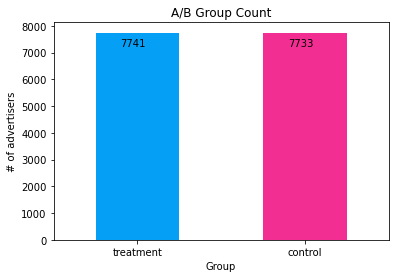

In [286]:
ax = experiment_count.plot(kind='bar', color=color_lst[:2], title='A/B Group Count',
                          xlabel='Group', ylabel='# of advertisers')

ax.set_xticklabels(['treatment', 'control'], rotation=0)


for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x() + 0.15, p.get_height() - 500))

fig = ax.get_figure()
fig.savefig('../images/ab_count')

In [287]:
mapping_dict = {True:'treatment', False:'control'}

experiment_prop = experiment.treatment.value_counts(normalize=True).rename(index=mapping_dict)
experiment_prop

treatment    0.500258
control      0.499742
Name: treatment, dtype: float64

In [288]:
company_size_prop = experiment.company_size.value_counts(normalize=True)
company_size_prop

small     0.575223
large     0.332558
medium    0.092219
Name: company_size, dtype: float64

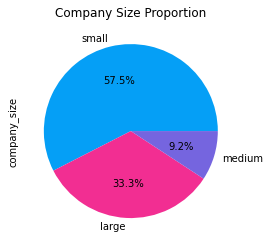

In [289]:
ax = company_size_prop.plot(kind='pie', autopct='%1.1f%%', title='Company Size Proportion')

fig = ax.get_figure()
fig.savefig('../images/company_size_pie');

In [290]:
company_size_count = pd.crosstab(experiment.company_size, experiment.treatment, colnames=['group'])
company_size_count.rename(columns=mapping_dict, inplace=True)
company_size_count

group,control,treatment
company_size,,
large,2701,2445
medium,735,692
small,4297,4604


In [291]:
company_size_pct = pd.crosstab(experiment.company_size, experiment.treatment, colnames=['group'],
                                normalize='index')
company_size_pct.rename(columns=mapping_dict, inplace=True)
company_size_pct

group,control,treatment
company_size,,
large,0.524874,0.475126
medium,0.515067,0.484933
small,0.482755,0.517245


''

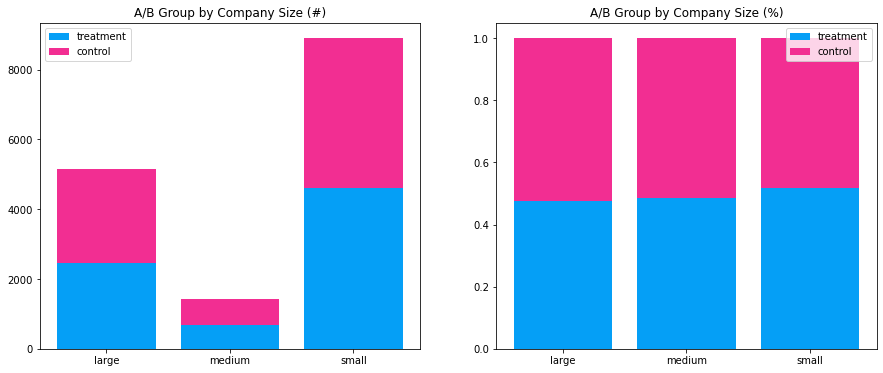

In [292]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))

for idx, (df_summary, sign) in enumerate(zip([company_size_count, company_size_pct], ['#', '%'])):
    axs[idx].bar(df_summary.index, df_summary.treatment, label='treatment')
    axs[idx].bar(df_summary.index, df_summary.control, bottom=df_summary.treatment, 
           label='control')

    axs[idx].set_title(f'A/B Group by Company Size ({sign})')
    axs[idx].legend()
    

fig.savefig(f'../images/ab_by_company_size.jpg')

;


In [293]:
def plot_distribution(df, col_name, title, separation_quantile):
    
#     print(f'The separation frequency is at ${df[col_name].quantile(separation_quantile):.1f}')
    
    for version in [True, False]
    df = df[df.treatment == False]
    
    
    # create a new dataframe with the data below than the separation quantile of the given column 
    lower_bound_dist = df[col_name][(df[col_name] < df[col_name].quantile(separation_quantile))]
    
    # create another dataframe with the data higher than the separation quantile of the given column 
    upper_bound_dist = df[col_name][(df[col_name] >= df[col_name].quantile(separation_quantile))]
    
    
    fig, axs = plt.subplots(2, figsize=(6,8), tight_layout=True)
    
    
    # plot the lower bound distribution and median
    axs[0].hist(lower_bound_dist) 
    axs[0].axvline(df[col_name].quantile(0.5), color='black', ls='--', 
                  label=f'median = {df[col_name].median():.1f}')
    
    axs[0].set_ylabel('frequency')
    axs[0].set_xlabel(col_name)
    axs[0].set_title(f'{separation_quantile*100:.0f}% of the Data Distribution', fontsize=14)
    axs[0].legend()
    
    # plot the upper bound distribution and mean    
    axs[1].hist(upper_bound_dist)
    axs[1].axvline(df[col_name].mean(), color='black', ls='--', 
                  label=f'mean = {df[col_name].mean():.1f}', alpha=0.5)

    axs[1].set_ylabel('frequency')
    axs[1].set_xlabel(col_name)
    axs[1].set_title(f'{100-separation_quantile*100:.0f}% of the Tail Data Distributiion', fontsize=14)
    axs[1].legend()
    
    fig.suptitle(title, fontsize=14)
    
    fig.savefig(f'../images/{col_name}_distribution.jpg')
    ;


SyntaxError: invalid syntax (<ipython-input-293-9c53681de033>, line 5)

In [294]:
def plot_distribution(ab_df, col_name, title, separation_quantile):
    
#     print(f'The separation frequency is at ${df[col_name].quantile(separation_quantile):.1f}')
    fig, axs = plt.subplots(2, 2, figsize=(12,8), tight_layout=True)
    
    for idx, version in enumerate([True, False]):
        df = ab_df[ab_df.treatment == version]


        # create a new dataframe with the data below than the separation quantile of the given column 
        lower_bound_dist = df[col_name][(df[col_name] < df[col_name].quantile(separation_quantile))]

        # create another dataframe with the data higher than the separation quantile of the given column 
        upper_bound_dist = df[col_name][(df[col_name] >= df[col_name].quantile(separation_quantile))]


        


        # plot the lower bound distribution and median
        axs[0,idx].hist(lower_bound_dist, color=color_lst[idx]) 
        axs[0,idx].axvline(df[col_name].quantile(0.5), color='black', ls='--', 
                      label=f'median = {df[col_name].median():.1f}')

        axs[0,idx].set_ylabel('frequency')
        axs[0,idx].set_xlabel(col_name)
        axs[0,idx].set_title(f'{separation_quantile*100:.0f}% of the Data Distribution', fontsize=14)
        axs[0,idx].legend()

        # plot the upper bound distribution and mean    
        axs[1,idx].hist(upper_bound_dist, color=color_lst[idx])
        axs[1,idx].axvline(df[col_name].mean(), color='black', ls='--', 
                      label=f'mean = {df[col_name].mean():.1f}', alpha=0.5)

        axs[1,idx].set_ylabel('frequency')
        axs[1,idx].set_xlabel(col_name)
        axs[1,idx].set_title(f'{100-separation_quantile*100:.0f}% of the Tail Data Distributiion', fontsize=14)
        axs[1,idx].legend()
    
    fig.suptitle(title + ' Treatment vs Control Group', fontsize=14)
    
    fig.savefig(f'../images/{col_name}_distribution.jpg')
    ;


In [295]:
experiment.describe().apply(lambda d: d.apply('{0:.1f}'.format))

,campaign_spend,campaign_budget,overspend
count,15474.0,15474.0,15474.0
mean,4903.0,5772.6,341.5
std,65166.9,99033.8,4079.1
min,0.4,0.1,0.0
25%,15.2,12.8,0.1
50%,50.1,48.8,2.2
75%,236.5,252.3,7.8
max,5289216.9,10242888.2,288590.2


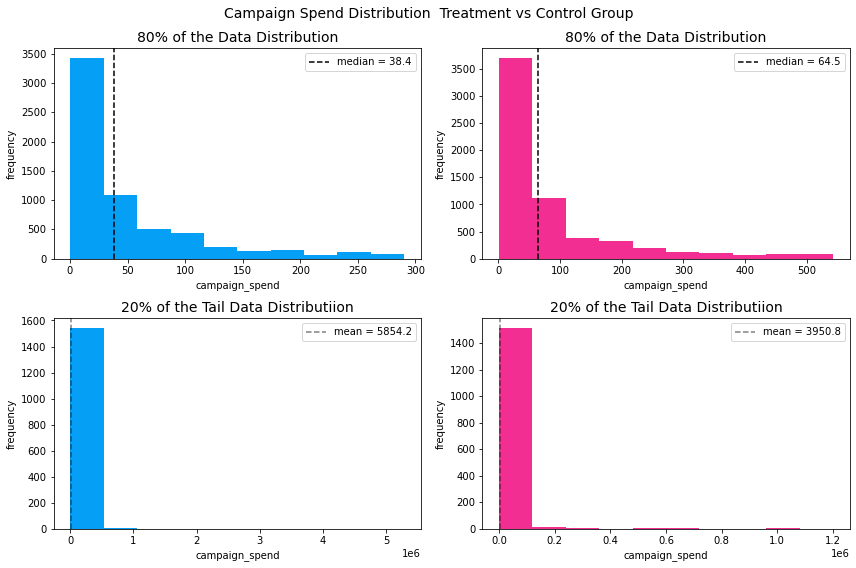

In [296]:
plot_distribution(experiment, 'campaign_spend', title='Campaign Spend Distribution ',
                  separation_quantile=0.8)

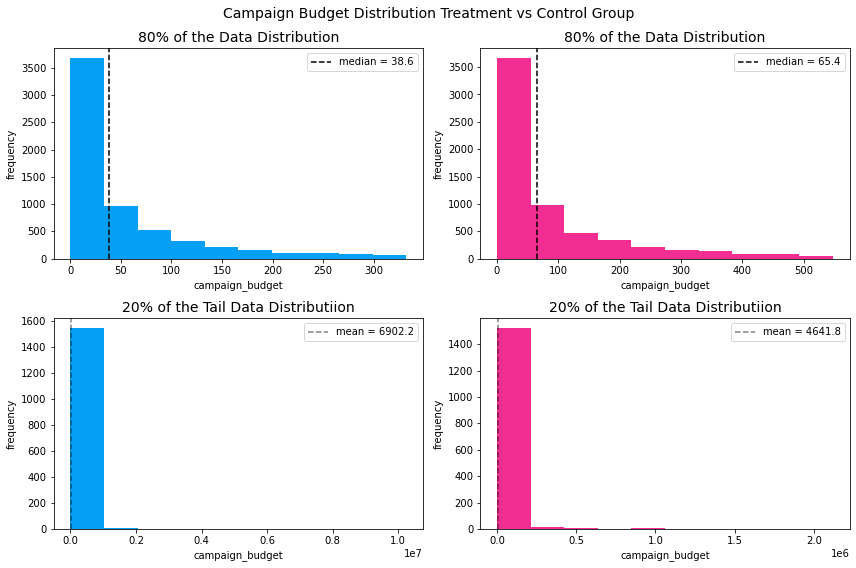

In [297]:
plot_distribution(experiment, 'campaign_budget', title='Campaign Budget Distribution', separation_quantile=0.8)

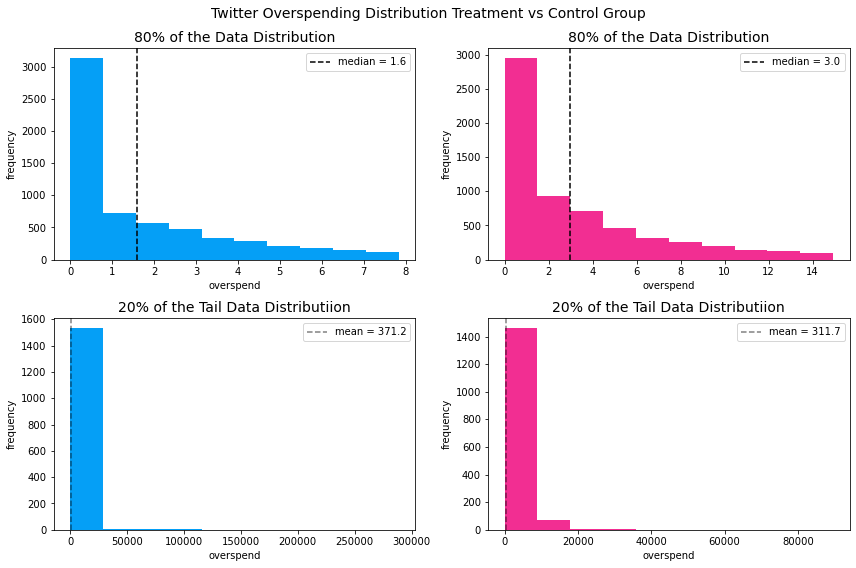

In [298]:
plot_distribution(experiment, 'overspend', title='Twitter Overspending Distribution', separation_quantile=0.8)

In [299]:
experiment.head()

,treatment,company_size,campaign_spend,campaign_budget,overspend
0,False,small,10.4477,3.9035,6.5442
1,False,medium,3.7776,1.9872,1.7904
2,False,medium,46.1880,55.4523,0.0000
3,False,small,6.6271,6.5136,0.1135
4,False,small,92.3405,83.1018,9.2387
